# Coronavirus Data Exploration

Getting and displaying COVID-19 data from https://covidtracking.com/. I thought it might be useful to make this a notebook, so other devs could see how to get the data. 

## Get the data 
Download and put it into a data frame. I am extracting data for the United States, and focusing on confirmed cases thus far (rather than deaths or recovery), but all that data is in the data set and it is easy to extract. 

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go

from state_codes import state_lat_long, us_state_abbrev

In [56]:
len(state_lat_long)

51

In [57]:
def extract_lat(input_state):
    return state_lat_long[input_state][0]

def extract_long(input_state):
    return state_lat_long[input_state][1]

In [58]:
extract_lat('WA')

47.751076

In [59]:
# total cases by state (and add long/lat)
totals_url = r'https://covidtracking.com/api/states.csv'
totals_df = pd.read_csv(totals_url)
totals_df.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,notes,hash
0,AK,321,1.0,1.0,1.0,1.0,A,4.0,9803,NaN,...,9.0,36.0,10124,10124,10124,2,2020-04-20T18:00:00Z,2020-04-20T18:17:00Z,"Please stop using the ""total"" field. Use ""tota...",e823271b095661adc50e7f229d7492a3df2ea389
1,AL,5025,1.0,1.0,0.0,1.0,B,3.0,40875,NaN,...,167.0,641.0,45900,45900,45900,1,2020-04-20T04:00:00Z,2020-04-20T20:07:00Z,"Please stop using the ""total"" field. Use ""tota...",c6b996ec01be6ed66115dababc8b7533d6d3f1d1
2,AR,1923,1.0,1.0,1.0,1.0,A,4.0,24630,NaN,...,42.0,291.0,26553,26553,26553,5,2020-04-20T18:30:00Z,2020-04-20T20:17:00Z,"Please stop using the ""total"" field. Use ""tota...",92f9b435057216bbade1752a1365c195323d6c83
3,AZ,5064,1.0,1.0,0.0,1.0,B,3.0,49436,NaN,...,187.0,NaN,54500,54500,54500,4,2020-04-20T04:00:00Z,2020-04-20T18:27:00Z,"Please stop using the ""total"" field. Use ""tota...",6c432f1410ee0235b5dcdaaec6f15b865d0b0c6d
4,CA,30978,1.0,1.0,0.0,1.0,B,3.0,259522,NaN,...,1208.0,NaN,290500,290500,290500,6,2020-04-19T04:00:00Z,2020-04-20T20:16:00Z,"Please stop using the ""total"" field. Use ""tota...",6a93111739f0c66fd386c8935f8f58f873bfc5ee


In [60]:
covid_us_totals = totals_df[['state','positive']]   #.iloc[:, [0,1]]
covid_us_totals = covid_us_totals.rename(columns = {'positive': 'cases'})
#covid_us_totals['lat'] = covid_us_totals.apply(extract_lat)
covid_us_totals.head()

,state,cases
0,AK,321
1,AL,5025
2,AR,1923
3,AZ,5064
4,CA,30978


In [61]:
daily_url = r'https://covidtracking.com/api/us/daily.csv'
daily_df = pd.read_csv(daily_url)
covid_time = daily_df[['date', 'positive']]
covid_time = covid_time.rename(columns = {'positive': 'cases'})
covid_time['date'] = pd.to_datetime(covid_time['date'], format = "%Y%m%d")
covid_time = covid_time.sort_values(by = 'date', ascending = True)
covid_time.head()

,date,cases
52,2020-02-28,9
51,2020-02-29,18
50,2020-03-01,40
49,2020-03-02,53
48,2020-03-03,94


## Some initial examination of data
Sorting is always fun if you want to be terrified. Would be fun to add a 'population' column and calculate the density of cases in each state instead of just the count.

In [62]:
sorted_by_cases = covid_us_totals.sort_values(by = ['cases'], ascending = False)
sorted_by_cases.head(10)

,state,cases
34,NY,247512
31,NJ,88806
19,MA,38077
38,PA,33232
22,MI,32000
14,IL,31508
4,CA,30978
9,FL,26660
18,LA,24523
6,CT,19815


I mean, this wouldn't be an analysis if we didn't plot the exponential rise of cases, would it?

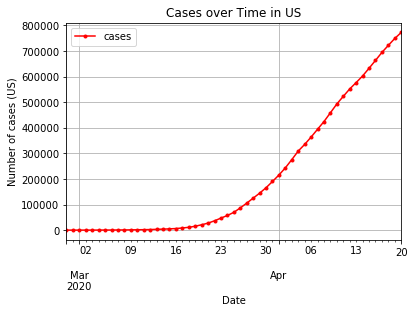

In [63]:
covid_time.plot(style = '.-', color = 'red', x = 'date', y = 'cases', grid = True);
plt.xlabel('Date')
plt.ylabel('Number of cases (US)')
plt.title('Cases over Time in US');

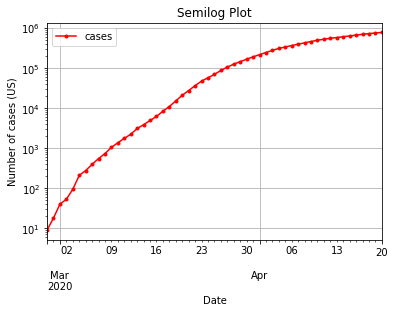

In [64]:
# same plot, semilog
covid_time.plot(style = '.-', logy = True, color = 'red', 
                x = 'date', y = 'cases',  grid = True);
plt.xlabel('Date')
plt.ylabel('Number of cases (US)')
plt.title('Semilog Plot');

Now we will start using plotly to make interactive plots we can show on a web site. For this first one, we will show the same time-series data, but in one plot with a dropdown menu that lets you select log or linear y axis. Ironically, *these plotly graphs will not show* when you are viewing this notebook in Github you need to run it in interactive mode.

In [65]:
# Plot in plotly with dropdown to select log vs linear
fig_time_dropit = go.Figure()
fig_time_dropit.add_trace(go.Scatter(x = covid_time['date'], y = covid_time['cases'],
                    mode='lines+markers',
                    name='Covid over Time',
                    line_color='red'))

fig_time_dropit.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label="Linear",
                    method="update",
                    args = [{'title': 'Linear scale'},
                            {'yaxis': {'type': 'linear'}}] ),
                dict(label="Log",
                    method="update",
                    args = [{'title': 'Log scale'},
                            {'yaxis': {'type': 'log'}}] )
            ]),
            direction="down",
            pad={"l": 10, "b": 10, "r": 10, "t": 10},
            showactive=True,
            x=0.04,
            xanchor="left",
            y=0.95,
            yanchor="top"),
    ],
    xaxis_title = "Date",
    yaxis_title = "#Cases",
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=0
    ),
)
fig_time_dropit.show()

In [66]:
plotly.offline.plot(fig_time_dropit, filename = 'docs/cases_v_time.html');

## On to maps
Plotly has soom cool geospatial data visualization functions. Let's use a couple of them.

In [67]:
# Filter out states that aren't in the map, and get latitude/longitude
state_filter = covid_us_totals["state"].isin(us_state_abbrev.values())
covid_us_totals = covid_us_totals[state_filter]
covid_us_totals['lat'] = covid_us_totals['state'].apply(extract_lat)
covid_us_totals['long'] = covid_us_totals['state'].apply(extract_long)
covid_us_totals.head()

,state,cases,lat,long
0,AK,321,66.160507,-153.369141
1,AL,5025,32.318230,-86.902298
2,AR,1923,34.799999,-92.199997
3,AZ,5064,34.048927,-111.093735
4,CA,30978,36.778259,-119.417931


### First up, heat map
These are known as *choropleths* to people in the know. TO normal people, they are heat maps. 

In [68]:
# Plot choropleth map (must use log otherwise it looks awful--too many orders of mag)
#tickvals= color_vals,
#ticktext= color_names),

fig = go.Figure(data=go.Choropleth(
    locations=covid_us_totals['state'], # Spatial coordinates
    z = np.log10(covid_us_totals['cases'].astype(float)), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text = covid_us_totals['cases'],
    colorbar=dict(len=0.65,
                  title='#Cases', 
                  tickprefix='1.e',
                  x=0.9,
                  tickvals = [0, 1, 2, 3, 3.699, 4, 4.398, 4.699, 5, 5.301],
                  ticktext = ['1', '10', '100', '1,000', '5,000','10,000', '25,000', 
                              '50,000', '100,000', '200,000'])))

fig.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=0
    ),
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [69]:
plotly.offline.plot(fig, filename = 'docs/choropleth.html');

### Bubble map
Note the need to manually make labels and add them as a column to the dataframe for it to show what we want on each bubble.

In [70]:
#Add column for labels
covid_w_labels = covid_us_totals
covid_w_labels['label'] = covid_us_totals['state'] + '<br>' + covid_us_totals['cases'].astype(str)
covid_w_labels.head(5)

# Set size bounds
size_vals = covid_us_totals['cases']
max_marker_size = 75
min_marker_size = 3
sizeref_scale = 2. * max(size_vals) / (max_marker_size ** 2)

# Plot, plotly, plot!
fig = go.Figure(data=go.Scattergeo(
        lon = covid_us_totals['long'],
        lat = covid_us_totals['lat'],
        mode='markers',
        text = covid_w_labels['label'],
        marker=dict(
            size=size_vals,
            sizemode='area',
            sizeref=sizeref_scale,
            sizemin=min_marker_size,
            color = 'Red',
        )))
     
fig.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=0
    ),
    geo_scope='usa', # limit map scope to USA
)


In [71]:
plotly.offline.plot(fig, filename = 'docs/bubble.html');

There we have it -- there is a lot more we could do (see the readme for a list), but this is enough to get started with the data!